In [1]:
import pandas as pd
import io
from google.colab import files, drive
import matplotlib.pyplot as plt
import re
import numpy as np
import plotly.express as px
import seaborn as sbrn

In [2]:
drive.mount('/content/drive/')
base_folder_string = '/content/drive/MyDrive/Colab Notebooks/TFM//'

Mounted at /content/drive/


---
# 0. Definición de funciones de útilidad:
---

In [3]:
def split_by_season(dataframe):
    # Group the dataframe by 'season' and create a dictionary of DataFrames for each season
    grouped = dataframe.groupby('season')
    season_dataframes = {str(season): group for season, group in grouped}
    return season_dataframes

In [4]:
def calculate_adjusted_df(dataframe, var_list, adj_stat):
    season_dataframes = split_by_season(dataframe)
    adjusted_dfs = {}  # Create a dictionary to store adjusted DataFrames for each season

    adj_functions = {'mean': pd.Series.mean, 'median': pd.Series.median}

    for season, df in season_dataframes.items():
        adjusted_df = pd.DataFrame()  # Initialize a DataFrame for each season

        for col in df.columns:
            #print(col)
            if col in var_list:  # Check if the column is in the specified list
                adjusted_df[col] = df[col]
            elif df[col].dtype in ['int64', 'float64']:
                adjusted_df[col + '_adj'] = df[col] / adj_functions[adj_stat](df[col])
            else:
                adjusted_df[col] = df[col]

        adjusted_dfs[season] = adjusted_df  # Store the adjusted DataFrame for the current season

    return adjusted_dfs

In [5]:
def separate_df_by_season(dataframe):
    # Get unique season values from the 'season' column
    unique_seasons = sorted(dataframe['season'].unique())

    # Create an empty list to store DataFrames for each season
    season_dfs_list = []

    # Iterate through unique seasons and create separate DataFrames
    for season_value in unique_seasons:
        # Filter the DataFrame for the current season value
        season_df = dataframe[dataframe['season'] == season_value].copy()
        season_dfs_list.append(season_df)

    return season_dfs_list

In [6]:
def calculate_adjusted_columns(df, columns_list):
    for col in columns_list:
        # Check if the column exists in the DataFrame
        if col in df.columns:
            adjusted_col_name = 'adj_' + col
            mean_value = df[col].mean()
            min_value = df[col].min()
            # =G3-MIN($F$3:$F$12) + AVERAGE($F$3:$F$12)

            df[adjusted_col_name] = (df[col] - min_value) + mean_value

    return df

In [7]:
def scale_column(df, columns_list):
  for col in columns_list:
    if col in df.columns:
        max_value = df[col].max()
        min_value = df[col].min()

        df[col] = (df[col] - min_value) / (max_value - min_value)

  return df

In [8]:
def concatenate_dataframes(dataframes):
    # Create a dictionary to group dataframes by columns
    grouped_dataframes = {}

    for df in dataframes:
        # Create a hashable representation of the DataFrame's columns
        df.columns = df.columns.str.lower()
        columns_key = tuple(sorted(df.columns))

        if columns_key in grouped_dataframes:
            # If columns match, append the DataFrame to the existing list
            grouped_dataframes[columns_key].append(df)
        else:
            # If columns don't match, create a new list for this set of columns
            grouped_dataframes[columns_key] = [df]

    concatenated_dataframes = []

    for key, df_list in grouped_dataframes.items():
        # Concatenate DataFrames with the same columns
        concatenated_df = pd.concat(df_list, ignore_index=True)
        concatenated_dataframes.append(concatenated_df)

    return concatenated_dataframes

In [9]:
# Función para encontrar duplicados en las columnas:

def find_duplicate_columns(df):
    duplicate_columns = set()
    columns = df.columns.tolist()

    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            col1 = df[columns[i]]
            col2 = df[columns[j]]

            if col1.equals(col2):
                duplicate_columns.add(columns[i])
                # duplicate_columns.add(columns[j])

    print(list(duplicate_columns))

    return list(duplicate_columns)

---
# 1.1. Var Redundantes dataset DEFENSIVO
---

In [10]:
def_feat_rs = pd.read_csv(base_folder_string + 'def_extended_for_feat_engin.csv', low_memory=False, index_col=0)
def_feat_poffs = pd.read_csv(base_folder_string + 'defense_ml_1997_2023.csv', low_memory=False, index_col=0)

In [11]:
pos_dic = { 'C': 5,
            'PF': 4,
            'SG': 2,
            'PG': 1,
            'SF': 3,
            'SF-SG': 32,
            'PG-SG': 12,
            'C-PF': 54,
            'PF-SF': 43,
            'SG-SF': 23,
            'SG-PG': 21,
            'PF-C': 45,
            'SF-PF': 34,
            'SG-PF': 24,
            'PG-SF': 13,
            'SF-C': 35,
            'SG-PG-SF': 213 }

In [12]:
def_feat_rs['pos_bpm'] = def_feat_rs['pos_bpm'].map(pos_dic)
def_feat_poffs['pos_bpm'] = def_feat_poffs['pos_bpm'].map(pos_dic)

Text(0.5, 1.0, 'Correlaciones con BPM DEFENSIVO Playoffs')

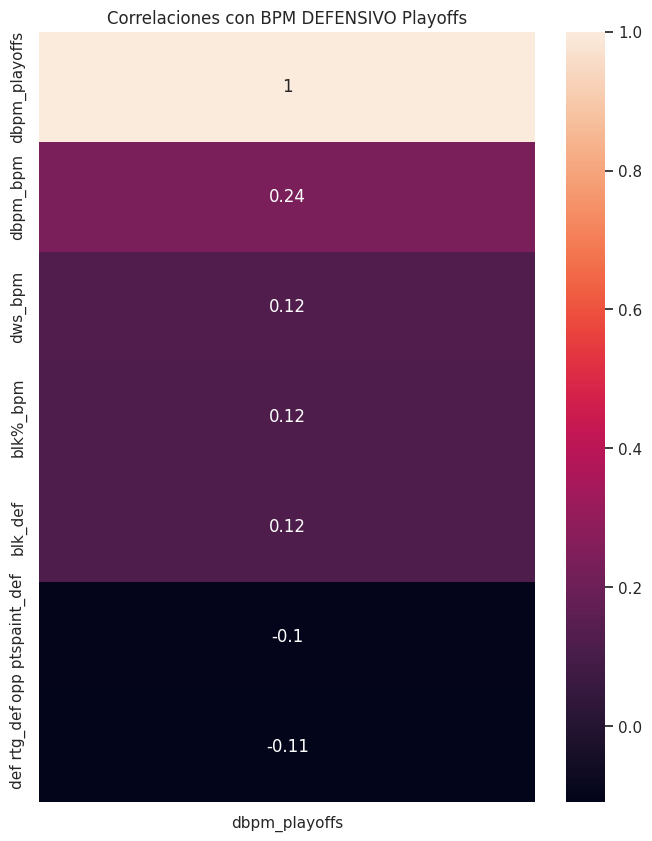

In [30]:
# Mapa de calor para revisar correlaciones con variable objetivo DBPM Playoffs

corr = def_feat_poffs.corr(numeric_only = True)
dbpm_corr = corr[["dbpm_playoffs"]]
dbpm_corr = dbpm_corr[(dbpm_corr["dbpm_playoffs"] > 0.1) | (dbpm_corr["dbpm_playoffs"] < -0.1)]

sbrn.set(rc = {'figure.figsize':(8, 10)})
heatmap = sbrn.heatmap(dbpm_corr.sort_values(by = ["dbpm_playoffs"], ascending = False), annot = True)
plt.title('Correlaciones con BPM DEFENSIVO Playoffs')

In [14]:
corr_dic = def_feat_rs.corr(numeric_only = True)
highly_correlated = {}  # Dictionary to store highly correlated pairs

threshold = 0.85  # Define the correlation threshold

# Iterate through the correlation matrix
for i in range(len(corr_dic.columns)):
    for j in range(i + 1, len(corr_dic.columns)):
        if abs(corr_dic.iloc[i, j]) > threshold:
            col_i = corr_dic.columns[i]
            col_j = corr_dic.columns[j]
            corr_value = corr_dic.iloc[i, j]
            pair = (col_i, col_j)
            highly_correlated[pair] = corr_value

# Print or work with the highly correlated pairs
if len(highly_correlated) > 0:
    print("Highly correlated pairs:")
    for pair, correlation in highly_correlated.items():
        print(f"{pair}: Correlation = {correlation}")
else:
    print("No highly correlated pairs found.")

Highly correlated pairs:
('age_bpm', 'age'): Correlation = 0.9934067945948541
('g_bpm', 'gp'): Correlation = 0.9998230597793478
('mp_bpm', 'poss_adv'): Correlation = 0.9971129557489965
('per_bpm', 'bpm_bpm'): Correlation = 0.8681224508954182
('per_bpm', 'pie_adv'): Correlation = 0.9461909008740099
('drb%_bpm', 'dreb_def'): Correlation = 0.9935726664435462
('drb%_bpm', 'dreb%_def'): Correlation = 0.9932467261656893
('drb%_bpm', '%dreb_def'): Correlation = 0.9840198648399083
('drb%_bpm', 'reb%_adv'): Correlation = 0.9462033681214349
('stl%_bpm', 'stl_def'): Correlation = 0.9961792612270863
('stl%_bpm', 'stl%_def'): Correlation = 0.9070928516667861
('blk%_bpm', 'blk_def'): Correlation = 0.9863617203965415
('blk%_bpm', '%blk_def'): Correlation = 0.9338608601087748
('ws_bpm', 'vorp_bpm'): Correlation = 0.9145642843781449
('ws/48_bpm', 'bpm_bpm'): Correlation = 0.8656419398171101
('bpm_bpm', 'pie_adv'): Correlation = 0.8781033524221686
('+/-_oncourt_pbp', 'netrtg_adv'): Correlation = 0.98310

In [15]:
redundant_feat_def = ['age_bpm', 'vorp_playoffs',
                      'g_bpm', 'poss_adv', 'bpm_playoffs',
                      'ws_bpm', 'per_bpm', 'ws/48_bpm',
                      'dreb%_def', 'reb%_adv', 'g_playoffs',
                      'stl%_bpm', 'Unnamed: 0',
                      '%blk_def',
                      'netrtg_adv',
                      'defws_def',
                      '+/-_oncourt_pbp']

In [16]:
def_feat_poffs = def_feat_poffs.drop(redundant_feat_def, axis=1)

In [17]:
def_feat_poffs.columns.values

array(['season', 'player', 'pos_bpm', 'mp_bpm', 'drb%_bpm', 'blk%_bpm',
       'dws_bpm', 'dbpm_bpm', 'bpm_bpm', 'vorp_bpm', '+/-_on-off_pbp',
       'fouls_committed_shoot_pbp', 'fouls_drawn_off_pbp', 'team', 'age',
       'gp', 'min', 'def\xa0rtg_def', 'dreb_def', '%dreb_def', 'stl_def',
       'stl%_def', 'blk_def', 'opp\xa0ptsoff\xa0tov_def',
       'opp\xa0pts2nd\xa0chance_def', 'opp\xa0ptsfb_def',
       'opp\xa0ptspaint_def', 'blka_misc', 'pf_misc', 'pie_adv',
       'mp_playoffs', 'dbpm_playoffs'], dtype=object)

---
# 1.2 Var Redundantes dataset OFENSIVO
---

In [23]:
off_feat_rs = pd.read_csv(base_folder_string + 'off_extended_for_feat_engin.csv', low_memory=False, index_col=0)
off_feat_poffs = pd.read_csv(base_folder_string + 'offense_ml_1997_2023.csv', low_memory=False, index_col=0)

In [26]:
off_feat_rs['pos_bpm'] = off_feat_rs['pos_bpm'].map(pos_dic)
off_feat_poffs['pos_bpm'] = off_feat_poffs['pos_bpm'].map(pos_dic)

off_feat_poffs = off_feat_poffs.drop('bpm_playoffs', axis=1)

Text(0.5, 1.0, 'Correlaciones con BPM OFENSIVO Playoffs')

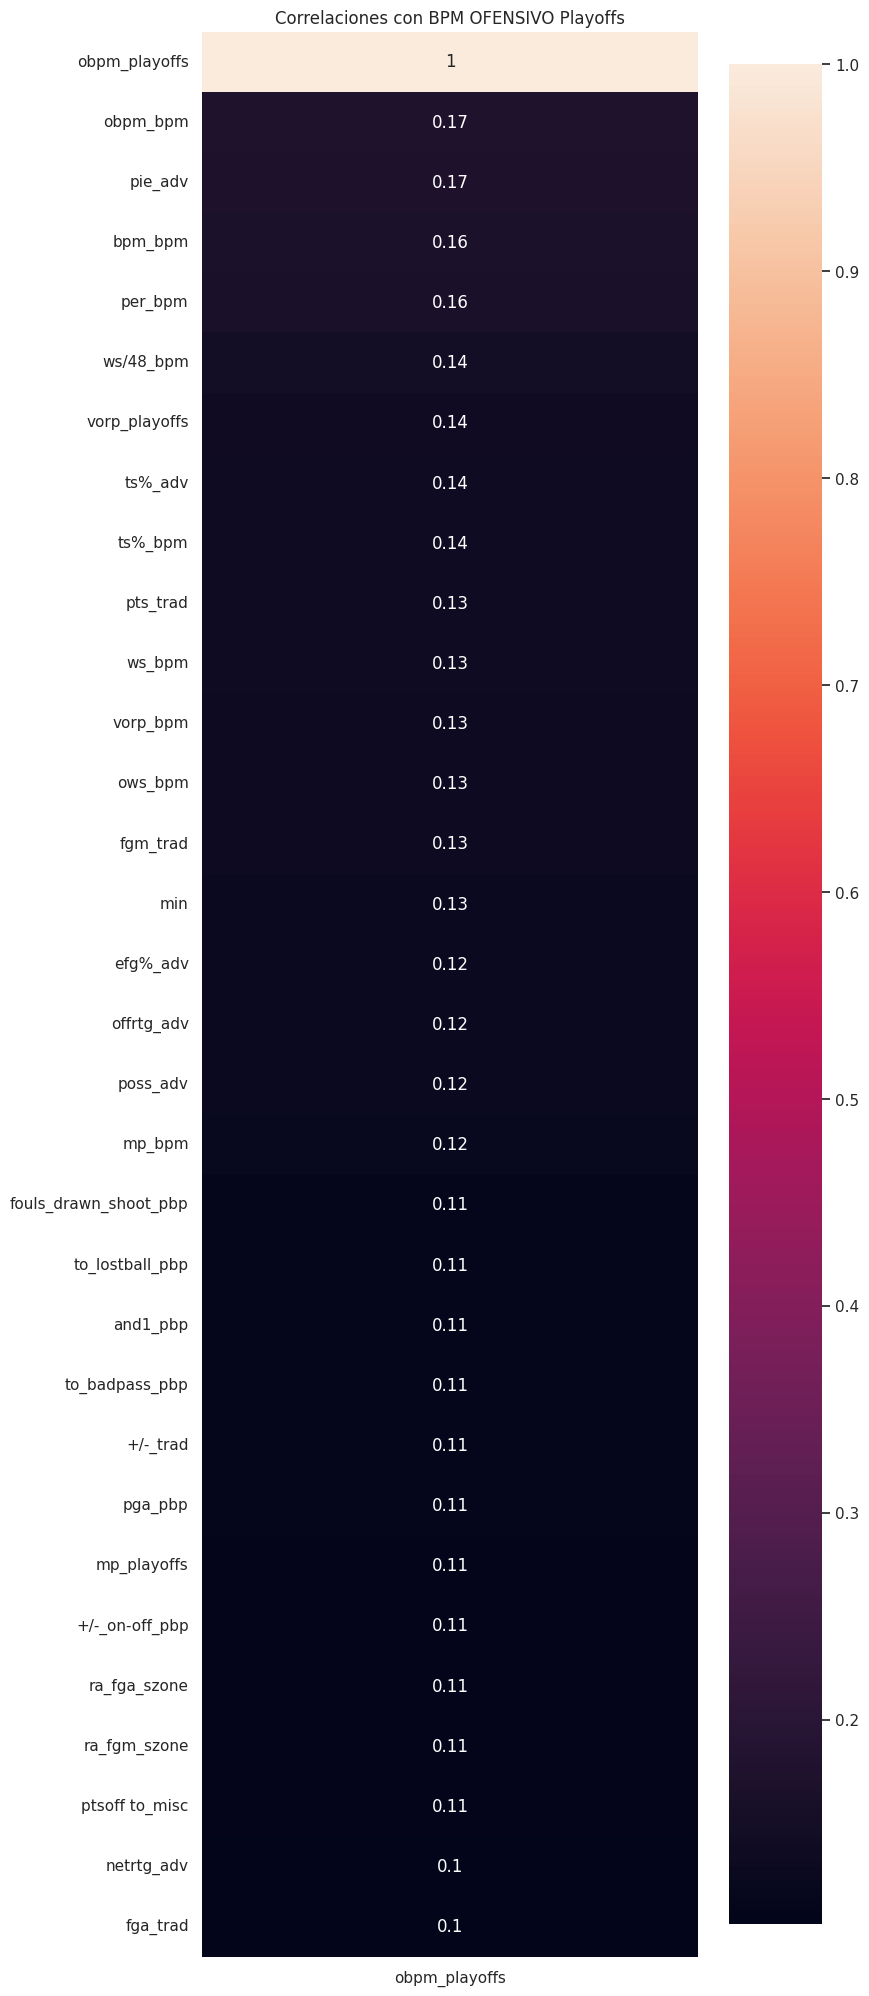

In [28]:
# Mapa de calor para revisar correlaciones con variable objetivo DBPM Playoffs

corr = off_feat_poffs.corr(numeric_only = True)
obpm_corr = corr[["obpm_playoffs"]]
obpm_corr = obpm_corr[(obpm_corr["obpm_playoffs"] > 0.1) | (obpm_corr["obpm_playoffs"] < -0.1)]

sbrn.set(rc = {'figure.figsize':(8, 25)})
heatmap = sbrn.heatmap(obpm_corr.sort_values(by = ["obpm_playoffs"], ascending = False), annot = True)
plt.title('Correlaciones con BPM OFENSIVO Playoffs')

In [ ]:
corr_dic = off_feat_rs.corr(numeric_only = True)
highly_correlated = {}  # Dictionary to store highly correlated pairs

threshold = 0.85  # Define the correlation threshold

# Iterate through the correlation matrix
for i in range(len(corr_dic.columns)):
    for j in range(i + 1, len(corr_dic.columns)):
        if abs(corr_dic.iloc[i, j]) > threshold:
            col_i = corr_dic.columns[i]
            col_j = corr_dic.columns[j]
            corr_value = corr_dic.iloc[i, j]
            pair = (col_i, col_j)
            highly_correlated[pair] = corr_value

# Print or work with the highly correlated pairs
if len(highly_correlated) > 0:
    print("Highly correlated pairs:")
    for pair, correlation in highly_correlated.items():
        print(f"{pair}: Correlation = {correlation}")
else:
    print("No highly correlated pairs found.")

Highly correlated pairs:
('g_bpm', 'gp'): Correlation = 0.9972129552820757
('mp_bpm', 'min'): Correlation = 0.9071226539682651
('mp_bpm', 'poss_adv'): Correlation = 0.9965433853074399
('per_bpm', 'obpm_bpm'): Correlation = 0.8902058290810071
('per_bpm', 'bpm_bpm'): Correlation = 0.8686580881449236
('per_bpm', 'pie_adv'): Correlation = 0.9449714229590817
('ts%_bpm', 'efg%_adv'): Correlation = 0.9365198231155646
('ts%_bpm', 'ts%_adv'): Correlation = 0.9903393312488089
('3par_bpm', 'dist_shoot'): Correlation = 0.8615912922060889
('3par_bpm', '%_fga_by_distance_2p_shoot'): Correlation = -0.999999965725436
('3par_bpm', '%fga2pt_scor'): Correlation = -0.9964097350999446
('3par_bpm', '%fga3pt_scor'): Correlation = 0.9964098072351761
('3par_bpm', '%pts2pt_scor'): Correlation = -0.9270335739450801
('3par_bpm', '%pts3pt_scor'): Correlation = 0.9712570795652414
('3par_bpm', '3pm_trad'): Correlation = 0.8915955318834984
('3par_bpm', '3pa_trad'): Correlation = 0.9223039753362828
('ftr_bpm', '%ptsft

In [ ]:
redundant_feat_off = ['g_bpm', 'vorp_playoffs',
                      'mp_bpm', 'bpm_playoffs',
                      'per_bpm', 'g_playoffs', 'Unnamed: 0',
                      'ts%_bpm', 'efg%_adv',
                      'orb%_bpm',
                      'ast%_adv',
                      'usg%_adv',
                      'ws_bpm',
                      '+/-_oncourt_pbp',
                      'fg%_shoot']

In [ ]:
off_feat_poffs = off_feat_poffs.drop(redundant_feat_off, axis=1)

In [ ]:
off_feat_poffs.columns.values

array(['season', 'player', 'pos_bpm', 'age_bpm', '3par_bpm', 'ftr_bpm',
       'ast%_bpm', 'tov%_bpm', 'usg%_bpm', 'ows_bpm', 'ws/48_bpm',
       'obpm_bpm', 'bpm_bpm', 'vorp_bpm', '+/-_on-off_pbp',
       'to_badpass_pbp', 'to_lostball_pbp', 'fouls_committed_off_pbp',
       'fouls_drawn_shoot_pbp', 'pga_pbp', 'and1_pbp', 'blocked_pbp',
       'dist_shoot', '%_fga_by_distance_2p_shoot',
       '%_fga_by_distance_0-3_shoot', '%_fga_by_distance_3-10_shoot',
       '%_fga_by_distance_10-16_shoot', '%_fga_by_distance_16-3p_shoot',
       'fg%_2p_shoot', 'fg%_0-3_shoot', 'fg%_3-10_shoot',
       'fg%_10-16_shoot', 'fg%_16-3p_shoot', 'fg%_3p_shoot',
       '%_fg_astd_2p_shoot', '%_fg_astd_3p_shoot', 'dunks_%fga_shoot',
       'dunks_#_shoot', 'corner_3s_%3pa_shoot', 'corner_3s_3p%_shoot',
       'heaves_att_shoot', 'team', 'gp', 'min', 'offrtg_adv',
       'netrtg_adv', 'ast/to_adv', 'ast\xa0ratio_adv', 'oreb%_adv',
       'to\xa0ratio_adv', 'ts%_adv', 'pace_adv', 'pie_adv', 'poss_adv',
   

---
# 2. Generación de Dataframes ajustados a la liga
---

In [ ]:
defvar_list = ['season', 'dbpm_bpm', 'bpm_bpm', 'vorp_bpm', 'age', 'age_bpm' 'g_playoffs', 'mp_playoffs', 'dbpm_playoffs', 'bpm_playoffs', 'vorp_playoffs']
offvar_list = ['season', 'obpm_bpm', 'bpm_bpm', 'vorp_bpm', 'age', 'age_bpm' 'g_playoffs', 'mp_playoffs', 'obpm_playoffs', 'bpm_playoffs', 'vorp_playoffs']

In [ ]:
%%capture

adj_def_median = calculate_adjusted_df(def_feat_poffs, var_list=defvar_list, adj_stat='median')
adj_def_mean = calculate_adjusted_df(def_feat_poffs, var_list=defvar_list, adj_stat='mean')

adj_off_median = calculate_adjusted_df(off_feat_poffs, var_list=offvar_list, adj_stat='median')
adj_off_mean = calculate_adjusted_df(off_feat_poffs, var_list=offvar_list, adj_stat='mean')

In [ ]:
# Convert the dictionary values (DataFrames) into a list
adjusted_dfs_med = list(adj_def_median.values())
def_adj_median = pd.concat(adjusted_dfs_med, ignore_index=True)

In [ ]:
# Convert the dictionary values (DataFrames) into a list
adjusted_dfs_mean = list(adj_def_mean.values())
def_adj_mean = pd.concat(adjusted_dfs_mean, ignore_index=True)

In [ ]:
# Convert the dictionary values (DataFrames) into a list
adjusted_dfs_med = list(adj_off_median.values())
off_adj_median = pd.concat(adjusted_dfs_med, ignore_index=True)

In [ ]:
# Convert the dictionary values (DataFrames) into a list
adjusted_dfs_mean = list(adj_off_mean.values())
off_adj_mean = pd.concat(adjusted_dfs_mean, ignore_index=True)

---
## 2.1. Correlaciones con DF AJUSTADOS
---

In [ ]:
# Revisión de correlaciones con variable objetivo DBPM Playoffs

corr_def = def_feat_poffs.corr(numeric_only = True)
corr_adj_median = def_adj_median.corr(numeric_only = True)
corr_adj_mean = def_adj_mean.corr(numeric_only = True)


dbpm_corr = corr_def["dbpm_playoffs"].tolist()
dbpm_corr_med = corr_adj_median["dbpm_playoffs"].tolist()
dbpm_corr_mean = corr_adj_mean["dbpm_playoffs"].tolist()

In [ ]:
def_ls = corr_def.columns.values

def_comp_df = pd.DataFrame({'dbpm_corr': dbpm_corr,
                            'dbpm_adj_median': dbpm_corr_med,
                            'dbpm_adj_mean': dbpm_corr_mean })

def_comp_df = def_comp_df.set_index(def_ls)

In [ ]:
def_comp_df.describe()

,dbpm_corr,dbpm_adj_median,dbpm_adj_mean
count,30.000000,30.000000,30.000000
mean,0.072406,0.068183,0.067187
std,0.189686,0.192017,0.192659
min,-0.108508,-0.130102,-0.132093
25%,0.013483,0.003520,0.000137
50%,0.048450,0.042473,0.043383
75%,0.087190,0.086890,0.087441
max,1.000000,1.000000,1.000000


In [ ]:
# Revisión de correlaciones con variable objetivo OBPM Playoffs

corr_off = off_feat_poffs.corr(numeric_only = True)
corr_adj_median = off_adj_median.corr(numeric_only = True)
corr_adj_mean = off_adj_mean.corr(numeric_only = True)


obpm_corr = abs(corr_off["obpm_playoffs"]).tolist()
obpm_corr_med = abs(corr_adj_median["obpm_playoffs"]).tolist()
obpm_corr_mean = abs(corr_adj_mean["obpm_playoffs"]).tolist()

In [ ]:
off_ls = corr_off.columns.values

off_comp_df = pd.DataFrame({'obpm_corr': obpm_corr,
                            'obpm_adj_median': obpm_corr_med,
                            'obpm_adj_mean': obpm_corr_mean })

off_comp_df = off_comp_df.set_index(off_ls)

In [ ]:
off_comp_df.describe()

,obpm_corr,obpm_adj_median,obpm_adj_mean
count,103.000000,103.000000,103.000000
mean,0.074387,0.074228,0.074214
std,0.101772,0.102248,0.102299
min,0.000039,0.000146,0.000614
25%,0.024196,0.023562,0.021860
50%,0.060678,0.062172,0.061639
75%,0.100076,0.099409,0.100635
max,1.000000,1.000000,1.000000


---
# 3. Generación de nuevas caracteristicas OFF
---

In [ ]:
off_seas_ls = separate_df_by_season(off_feat_poffs)

In [ ]:
test_df = off_seas_ls[10].copy()

In [ ]:
test_df.head(2)

,season,player,pos_bpm,age_bpm,3par_bpm,ftr_bpm,ast%_bpm,tov%_bpm,usg%_bpm,ows_bpm,...,3p%_trad,ftm_trad,fta_trad,ft%_trad,oreb_trad,ast_trad,tov_trad,+/-_trad,mp_playoffs,obpm_playoffs
1847,2007,Adonal Foyle,5,31,0.000,0.294,5.5,19.3,10.7,0.4,...,0.0,1.1,2.5,44.0,5.1,1.9,2.3,-5.1,6,6.4
1848,2007,Adrian Griffin,3,32,0.047,0.147,15.2,21.7,13.3,0.1,...,0.0,1.3,1.7,78.9,3.5,5.2,3.3,6.5,9,-19.2


In [ ]:
off_col_adj = ['ts%_adv', 'pts_trad']
test_df = calculate_adjusted_columns(test_df, off_col_adj)

In [ ]:
# Cálculo de Scoring impact

test_df['scoring_impact'] = (test_df['pts_trad'] * (test_df['ts%_adv']/100)) + (test_df['adj_ts%_adv']/10)

In [ ]:
scorimp_ls = ['player', 'season', 'mp_playoffs', 'pts_trad', 'adj_pts_trad','ts%_adv', 'adj_ts%_adv', 'scoring_impact', 'obpm_playoffs']
scoring_df = test_df[scorimp_ls]

In [ ]:
scoring_df = scoring_df.apply(pd.to_numeric, errors='ignore')

In [ ]:
corr = scoring_df.corr(numeric_only = True)
scoring_corr = corr["obpm_playoffs"]

In [ ]:
scoring_corr.sort_values(ascending=True)

ts%_adv           0.211064
adj_ts%_adv       0.211064
adj_pts_trad      0.266927
pts_trad          0.266927
mp_playoffs       0.285628
scoring_impact    0.287166
obpm_playoffs     1.000000
season                 NaN
Name: obpm_playoffs, dtype: float64

In [ ]:
# Fórmula y variables para rim pressure:

test_df = calculate_adjusted_columns(test_df, ['ra_fg%_szone'])

test_df['rim_pressure'] = ((test_df['ra_fga_szone']) * (test_df['adj_ra_fg%_szone']/100)) + ((test_df['and1_pbp'] + test_df['paint_fgm_szone'])/10)

rim_pressure_ls = ['player', 'season', 'mp_playoffs', 'fta_trad', 'and1_pbp', 'paint_fgm_szone', 'ra_fg%_szone',
                  'ra_fga_szone', 'dunks_#_shoot', 'rim_pressure', 'obpm_playoffs']

rimpres_df = test_df[rim_pressure_ls]

In [ ]:
corr = rimpres_df.corr(numeric_only = True)
rimpres_corr = corr["obpm_playoffs"]

In [ ]:
rimpres_corr.sort_values(ascending=True)

ra_fg%_szone       0.157240
dunks_#_shoot      0.167944
paint_fgm_szone    0.271217
mp_playoffs        0.285628
ra_fga_szone       0.321789
and1_pbp           0.325616
rim_pressure       0.333369
fta_trad           0.373559
obpm_playoffs      1.000000
season                  NaN
Name: obpm_playoffs, dtype: float64

In [ ]:
# Fórmula y variables para OFF-BALL 3point shooting ability:

test_df["offball_3pshoot"] = (((test_df['3par_bpm'] * test_df['dist_shoot'])/100) * test_df['3p%_trad']) + (test_df['%_fg_astd_3p_shoot']/10)

test_df["offball_3pshoot"] = test_df["offball_3pshoot"].fillna(0)

stationary_shooting_ls = ['player', 'season', 'mp_playoffs', 'dist_shoot',
                          'ft%_trad', '3pm_trad', '3par_bpm', '3p%_trad', 'offball_3pshoot', 'obpm_playoffs']

stationshoot_df = test_df[stationary_shooting_ls]

In [ ]:
corr = stationshoot_df.corr(numeric_only = True)
stationshoot_corr = corr["obpm_playoffs"]

In [ ]:
stationshoot_corr.sort_values(ascending=True)

dist_shoot        -0.076159
offball_3pshoot   -0.048024
3par_bpm          -0.041955
3pm_trad          -0.024227
3p%_trad           0.011744
ft%_trad           0.045527
mp_playoffs        0.285628
obpm_playoffs      1.000000
season                  NaN
Name: obpm_playoffs, dtype: float64

In [ ]:
# Fórmula y variables para OFF-BALL 2point shooting ability:

test_df = calculate_adjusted_columns(test_df, ['fg%_2p_shoot'])

test_df["offball_2pshoot"] = ((test_df['fga_trad'] * (test_df['%fga2pt_scor']/100)) * test_df['adj_fg%_2p_shoot']) + (test_df['%_fg_astd_2p_shoot'] * 10)

test_df["offball_2pshoot"] = test_df["offball_2pshoot"].fillna(0)

offball_2p_shoot_ls = ['player', 'season', 'mp_playoffs', 'fga_trad', '%_fg_astd_2p_shoot', '%fga2pt_scor', 'adj_fg%_2p_shoot', 'offball_2pshoot', 'obpm_playoffs']

offball_2p_df = test_df[offball_2p_shoot_ls]

In [ ]:
corr = offball_2p_df.corr(numeric_only = True)
offball2p_corr = corr["obpm_playoffs"]

In [ ]:
offball2p_corr.sort_values(ascending=True)

%_fg_astd_2p_shoot   -0.174567
%fga2pt_scor          0.041973
offball_2pshoot       0.097291
adj_fg%_2p_shoot      0.124617
fga_trad              0.157007
mp_playoffs           0.285628
obpm_playoffs         1.000000
season                     NaN
Name: obpm_playoffs, dtype: float64

In [ ]:
# Fórmula y variables para ON-BALL 3point shooting ability:

test_df = calculate_adjusted_columns(test_df, ['3p%_trad', 'ab3_fgm_szone'])

test_df["onball_3pshoot"] = (test_df['3pa_trad'] * (test_df['adj_3p%_trad']/100)) * ((test_df['3fgm%uast_scor']/100) * test_df['adj_ab3_fgm_szone'])

onball_3p_shoot_ls = ['player', 'season', 'mp_playoffs', '3pa_trad', 'adj_3p%_trad', '3fgm%uast_scor', 'adj_ab3_fgm_szone', 'onball_3pshoot', 'obpm_playoffs']

offball_2p_df = test_df[onball_3p_shoot_ls]

In [ ]:
offball2p_corr.sort_values(ascending=True)

%_fg_astd_2p_shoot   -0.174567
%fga2pt_scor          0.041973
offball_2pshoot       0.097291
adj_fg%_2p_shoot      0.124617
fga_trad              0.157007
mp_playoffs           0.285628
obpm_playoffs         1.000000
season                     NaN
Name: obpm_playoffs, dtype: float64

In [ ]:
# Fórmula y variables para ON-BALL MIDRANGE shooting ability:

test_df = calculate_adjusted_columns(test_df, ['mr_fga_szone', 'mr_fg%_szone'])

test_df["onball_mr_shoot"] = (test_df['mr_fga_szone'] * (test_df['mr_fg%_szone']/100)) * ((test_df['2fgm%uast_scor']/100) + test_df['fg%_10-16_shoot'])

onball_mr_shoot_ls = ['player', 'season', 'mp_playoffs', 'adj_mr_fga_szone', 'adj_mr_fg%_szone', '2fgm%uast_scor', 'fg%_10-16_shoot', 'onball_mr_shoot', 'obpm_playoffs']

onball_mr_df = test_df[onball_mr_shoot_ls]

In [ ]:
corr = onball_mr_df.corr(numeric_only = True)
onball_mr_corr = corr["obpm_playoffs"]

In [ ]:
onball_mr_corr.sort_values(ascending=True)

fg%_10-16_shoot     0.030510
adj_mr_fg%_szone    0.128423
2fgm%uast_scor      0.174567
adj_mr_fga_szone    0.252320
onball_mr_shoot     0.272862
mp_playoffs         0.285628
obpm_playoffs       1.000000
season                   NaN
Name: obpm_playoffs, dtype: float64

In [ ]:
# Fórmula y variables para OFFENSIVE LOAD:

test_df = calculate_adjusted_columns(test_df, ['mr_fga_szone', 'mr_fg%_szone'])

test_df["off_load"] = (test_df['fga_trad'] * test_df['ftr_bpm']) * ((test_df['ast%_bpm'] + test_df['tov%_bpm'] + test_df['usg%_bpm'])/100)

off_load_ls = ['player', 'season', 'mp_playoffs', 'fga_trad', 'ftr_bpm', 'ast%_bpm', 'tov%_bpm', 'usg%_bpm', 'off_load', 'obpm_playoffs']

off_load_df = test_df[off_load_ls]

In [ ]:
corr = off_load_df.corr(numeric_only = True)
oload_corr = corr["obpm_playoffs"]

In [ ]:
oload_corr.sort_values(ascending=True)

tov%_bpm         0.151912
fga_trad         0.157007
ast%_bpm         0.171620
usg%_bpm         0.241242
ftr_bpm          0.285310
mp_playoffs      0.285628
off_load         0.371862
obpm_playoffs    1.000000
season                NaN
Name: obpm_playoffs, dtype: float64

In [ ]:
test_df.columns.values

array(['season', 'player', 'pos_bpm', 'age_bpm', '3par_bpm', 'ftr_bpm',
       'ast%_bpm', 'tov%_bpm', 'usg%_bpm', 'ows_bpm', 'ws/48_bpm',
       'obpm_bpm', 'bpm_bpm', 'vorp_bpm', '+/-_on-off_pbp',
       'to_badpass_pbp', 'to_lostball_pbp', 'fouls_committed_off_pbp',
       'fouls_drawn_shoot_pbp', 'pga_pbp', 'and1_pbp', 'blocked_pbp',
       'dist_shoot', '%_fga_by_distance_2p_shoot',
       '%_fga_by_distance_0-3_shoot', '%_fga_by_distance_3-10_shoot',
       '%_fga_by_distance_10-16_shoot', '%_fga_by_distance_16-3p_shoot',
       'fg%_2p_shoot', 'fg%_0-3_shoot', 'fg%_3-10_shoot',
       'fg%_10-16_shoot', 'fg%_16-3p_shoot', 'fg%_3p_shoot',
       '%_fg_astd_2p_shoot', '%_fg_astd_3p_shoot', 'dunks_%fga_shoot',
       'dunks_#_shoot', 'corner_3s_%3pa_shoot', 'corner_3s_3p%_shoot',
       'heaves_att_shoot', 'team', 'gp', 'min', 'offrtg_adv',
       'netrtg_adv', 'ast/to_adv', 'ast\xa0ratio_adv', 'oreb%_adv',
       'to\xa0ratio_adv', 'ts%_adv', 'pace_adv', 'pie_adv', 'poss_adv',
   

In [ ]:
# Fórmula y variables para PASSING IMPACT:
#  pass_val['ADJ_OFLD'] + (pass_val['ASLD_RT'] * 3) - (pass_val['TVLD_RT'] * 2) + (pass_val['CRLD_RT'] / 2) + (pass_val['AST_Con%'] * pass_val['AST\xa0PTSCreated.1'] / 100)

test_df = calculate_adjusted_columns(test_df, ['mr_fga_szone', 'mr_fg%_szone'])

test_df["pass_impact"] = ((test_df['to_badpass_pbp'] + test_df['pga_pbp']) / test_df['gp']) + ((test_df['ast_trad']/100) / test_df['off_load'])

pass_impact_ls = ['player', 'season', 'gp', 'mp_playoffs', 'pga_pbp', 'to_badpass_pbp', 'off_load', 'ast_trad', 'pass_impact', 'obpm_playoffs']

pass_impact = test_df[pass_impact_ls]

In [ ]:
pass_impact.sort_values(by = 'pass_impact', ascending=False)

,player,season,gp,mp_playoffs,pga_pbp,to_badpass_pbp,off_load,ast_trad,pass_impact,obpm_playoffs
2019,Steve Nash,2007,76,413,1965,223,4.249928,16.2,28.827592,6.4
1940,Jason Kidd,2007,80,484,1652,150,3.145751,12.9,22.566008,5.0
1900,Deron Williams,2007,80,657,1623,135,4.163878,13.0,22.006221,3.3
1867,Baron Davis,2007,63,445,1167,107,6.171168,11.0,20.240047,5.8
2020,TJ Ford,2007,75,136,1336,130,5.913960,13.5,19.569494,7.2
...,...,...,...,...,...,...,...,...,...,...
1991,Nazr Mohammed,2007,51,6,20,7,1.964704,0.6,0.532466,15.2
1950,Josh Boone,2007,61,118,22,6,2.578246,0.8,0.462119,-3.3
1931,Jake Tsakalidis,2007,36,3,12,3,1.928111,0.7,0.420297,27.0
1926,Ira Newble,2007,15,10,4,2,0.934497,0.8,0.408561,-13.2


In [ ]:
corr = pass_impact.corr(numeric_only = True)
pass_impact_corr = corr["obpm_playoffs"]

In [ ]:
pass_impact_corr.sort_values(ascending=True)

gp                0.093369
ast_trad          0.148637
pga_pbp           0.274332
pass_impact       0.280626
mp_playoffs       0.285628
to_badpass_pbp    0.287761
off_load          0.371862
obpm_playoffs     1.000000
season                 NaN
Name: obpm_playoffs, dtype: float64

---
# 3.1. Cálculo de nuevas variables y análisis de correlación OFF
---

In [ ]:
overall_3pshoot_ls = ['player', 'season', 'mp_playoffs', 'offball_3pshoot', 'onball_3pshoot',
                      '3pshoot_impact', 'scor_ver', 'obpm_playoffs']

off_reb = ['player', 'season', 'mp_playoffs', 'adj_oreb_trad', 'oreb%_adv', '2ndpts_misc', 'oreb_impact', 'obpm_playoffs']

In [ ]:
off_col_adj = ['ts%_adv', 'ts%_adv', 'ra_fg%_szone', 'fg%_2p_shoot', '3p%_trad', 'ab3_fgm_szone',
               'mr_fga_szone', 'mr_fg%_szone', 'oreb_trad']

for df in off_seas_ls:
  df = calculate_adjusted_columns(df, off_col_adj)
  # SCORING
  df['scoring_impact'] = (df['pts_trad'] * (df['ts%_adv']/100)) + (df['adj_ts%_adv']/10)
  # RIM PRESSURE
  df['rim_pressure'] = ((df['ra_fga_szone']) * (df['adj_ra_fg%_szone']/100)) + ((df['and1_pbp'] + df['paint_fgm_szone'])/10)
  # OFFBALL 2P
  df["offball_2pshoot"] = ((df['fga_trad'] * (df['%fga2pt_scor']/100)) * df['adj_fg%_2p_shoot']) + (df['%_fg_astd_2p_shoot'] * 10)
  # OFFBALL 3P
  df["offball_3pshoot"] = (((df['3par_bpm'] * df['dist_shoot'])/100) * df['3p%_trad']) + (df['%_fg_astd_3p_shoot']/10)
  # ONBALL 3P
  df["onball_3pshoot"] = (df['3pa_trad'] * (df['adj_3p%_trad']/100)) * ((df['3fgm%uast_scor']/100) * df['adj_ab3_fgm_szone'])
  # OVERALL 3P
  df["3pshoot_impact"] = df["onball_3pshoot"] + df["offball_3pshoot"]
  df['3pshoot_impact'] = df['3pshoot_impact'].fillna(0)
  # ONBALL MidRange
  df["onball_mr_shoot"] = (df['mr_fga_szone'] * (df['mr_fg%_szone']/100)) * ((df['2fgm%uast_scor']/100) + df['fg%_10-16_shoot'])
  df['onball_mr_shoot'] = df['onball_mr_shoot'].fillna(0)
  # OFFENSIVE LOAD
  df["off_load"] = (df['fga_trad'] * df['ftr_bpm']) * ((df['ast%_bpm'] + df['tov%_bpm'] + df['usg%_bpm'])/100)
  # PASSING IMPACT
  df["pass_impact"] = (((df['to_badpass_pbp'] * (df['ast%_bpm']/100)) + df['pga_pbp']) / df['gp']) + (df['ast_trad'] / 1 + df['off_load'])
  # OFF REBOUNDS IMPACT
  df['oreb_impact'] = ((df['adj_oreb_trad'] + df['2ndpts_misc']) * (df['oreb%_adv']/100))
  # SCORING VERSATILITY
  df = scale_column(df, ["3pshoot_impact", "onball_mr_shoot", 'rim_pressure', "offball_2pshoot"])
  df['scor_ver'] = df['rim_pressure'] + df['onball_mr_shoot'] + df['3pshoot_impact'] + df['offball_2pshoot']

  df = df.fillna(0)

In [ ]:
concat_adj_off_newvar = concatenate_dataframes(off_seas_ls)
concat_adj_off_newvar = concat_adj_off_newvar[0]

In [ ]:
new_var_df = concat_adj_off_newvar[overall_3pshoot_ls]
new_var_df = new_var_df[new_var_df['mp_playoffs'] > 30]
new_var_df.sort_values(by='3pshoot_impact', ascending=False).head(15)

,player,season,mp_playoffs,offball_3pshoot,onball_3pshoot,3pshoot_impact,scor_ver,obpm_playoffs
627,Jason Williams,2000,145,2.775935,5.884006,1.0,1.425682,-0.9
4519,James Harden,2020,448,3.299501,45.852581,1.0,2.011323,7.5
1517,Damon Jones,2005,498,6.747884,3.863939,1.0,1.246163,3.6
3189,Stephen Curry,2013,497,3.681776,9.451685,1.0,2.320807,4.5
1691,Chauncey Billups,2006,705,3.140020,6.420439,1.0,1.862372,3.6
3596,Stephen Curry,2015,826,3.709695,12.066916,1.0,2.335149,7.7
2455,Chauncey Billups,2010,207,2.746987,5.699302,1.0,1.911702,4.4
1972,Luther Head,2007,141,4.650543,2.854356,1.0,1.493375,-5.5
1293,Baron Davis,2004,260,2.051125,8.290542,1.0,2.201433,4.6
893,Tim Hardaway,2001,36,3.526038,6.745737,1.0,1.600012,-7.4


In [ ]:
# Define the names of the features/columns you want to calculate the correlation for
selected_feature_1 = 'obpm_playoffs'
selected_feature_2 = 'scor_ver'

# Loop through each DataFrame in the list and calculate the correlation
for idx, df in enumerate(off_seas_ls):
    # Calculate the correlation between the selected features
    correlation_score = df[[selected_feature_1, selected_feature_2]].corr().iloc[0, 1]

    # Print the correlation score for the current DataFrame
    print(f"Corr DF {idx + 1} = {correlation_score}")

Corr DF 1 = 0.11697108543817462
Corr DF 2 = 0.403314966854573
Corr DF 3 = 0.18045557535820833
Corr DF 4 = 0.4152487692401436
Corr DF 5 = 0.1346005442902463
Corr DF 6 = 0.340671547073662
Corr DF 7 = 0.47899093597963094
Corr DF 8 = 0.3428942656560649
Corr DF 9 = 0.23795188309073836
Corr DF 10 = 0.4374306025229386
Corr DF 11 = 0.2973870160267671
Corr DF 12 = 0.27995824317401397
Corr DF 13 = 0.34969070103513045
Corr DF 14 = 0.35540194147927867
Corr DF 15 = 0.2440004894898934
Corr DF 16 = 0.35542585993910497
Corr DF 17 = 0.2944128676679616
Corr DF 18 = 0.13052983194047985
Corr DF 19 = 0.3323932993671073
Corr DF 20 = 0.23931660962175053
Corr DF 21 = 0.30552727339325325
Corr DF 22 = 0.2861796731431151
Corr DF 23 = 0.30914470629213314
Corr DF 24 = 0.3594627299992564
Corr DF 25 = 0.40281230626861647
Corr DF 26 = 0.15893685351974687
Corr DF 27 = 0.33042540452056024


In [ ]:
# Correlaciones con variable objetivo OBPM Playoffs

corr = concat_adj_off_newvar.corr(numeric_only = True)
obpm_corr = corr[["obpm_playoffs"]]
obpm_corr.sort_values(by='obpm_playoffs', ascending=False)

,obpm_playoffs
obpm_playoffs,1.000000
obpm_bpm,0.174641
pie_adv,0.168672
bpm_bpm,0.164887
ws/48_bpm,0.144799
...,...
fgm%ast_scor,-0.043474
2fgm%ast_scor,-0.054247
%_fg_astd_2p_shoot,-0.054315
tov%_bpm,-0.057444


In [ ]:
cut_pos_val = 0.01
cut_neg_val = -0.01

In [ ]:
obpm_corr = obpm_corr[(obpm_corr["obpm_playoffs"] > cut_pos_val) | (obpm_corr["obpm_playoffs"] < cut_neg_val)]

In [ ]:
trans_obpm_corr = obpm_corr.T  # Using .T attribute to transpose the DataFrame

In [ ]:
off_keep_col = list(trans_obpm_corr.columns)

---
# 3.2. Exportación de dataframe OFENSIVO 1997-2023 para ML
---

In [ ]:
new_off_col = ['player', 'season', 'pos_bpm', 'gp', 'min', 'scoring_impact', 'rim_pressure', 'offball_2pshoot', 'offball_3pshoot',
               'onball_3pshoot', '3pshoot_impact', 'onball_mr_shoot', 'off_load', 'pass_impact', 'oreb_impact',
               'obpm_bpm', 'pie_adv', 'ws/48_bpm', 'offrtg_adv', 'mp_playoffs', 'obpm_playoffs']

In [ ]:
new_off_col.extend(x for x in off_keep_col if x not in new_off_col)

In [ ]:
new_var_odf = concat_adj_off_newvar[new_off_col]
new_var_odf = new_var_odf[new_var_odf['mp_playoffs'] > 35]
new_var_odf = new_var_odf.drop('mp_playoffs', axis=1)
new_var_odf = new_var_odf.fillna(0)

In [ ]:
new_var_odf.sort_values(by='obpm_playoffs', ascending=False).head(5)

,player,season,pos_bpm,gp,min,scoring_impact,rim_pressure,offball_2pshoot,offball_3pshoot,onball_3pshoot,...,+/-_trad,adj_ts%_adv,adj_ra_fg%_szone,adj_fg%_2p_shoot,adj_3p%_trad,adj_ab3_fgm_szone,adj_mr_fga_szone,adj_mr_fg%_szone,adj_oreb_trad,scor_ver
549,Voshon Lenard,1999,2,12,15.7,18.926766,0.024168,0.437645,3.130680,0.491420,...,-11.8,70.440659,87.628571,0.621275,55.289560,1.029670,5.645055,84.145604,3.755495,1.023179
2340,LeBron James,2009,3,81,37.7,31.679129,0.998742,0.830296,1.139485,4.346766,...,15.1,80.982292,130.262500,0.762792,61.717187,1.825000,8.929688,73.627604,4.326563,2.934644
4683,Damian Lillard,2021,1,67,35.8,32.892957,0.472634,0.473785,3.734719,29.321144,...,3.9,89.074569,123.115086,1.037522,71.420690,4.831034,3.556034,78.500431,2.730603,2.277426
3930,Kawhi Leonard,2017,3,74,33.4,31.328075,0.468391,0.703038,1.737280,2.673519,...,8.9,77.820755,124.077358,1.028429,68.307547,2.272642,7.969811,85.147642,3.650472,1.947197
2474,Dwyane Wade,2010,2,77,36.3,28.988005,0.942242,0.812600,0.566960,2.419453,...,6.6,76.882051,126.813333,0.790169,54.935897,1.322564,9.128205,73.348205,4.260000,2.691031


In [ ]:
new_var_odf.to_csv(base_folder_string + 'off_ext_feature_analysis_newvar.csv', index=False)

---
# 4. Generación de nuevas caracteristicas DEF
---

In [ ]:
def_seas_ls = separate_df_by_season(def_feat_poffs)

In [ ]:
test_def = def_seas_ls[np.random.randint(0, 27)].copy()

In [ ]:
test_def.head(2)

,season,player,pos_bpm,mp_bpm,drb%_bpm,blk%_bpm,dws_bpm,dbpm_bpm,bpm_bpm,vorp_bpm,...,blk_def,opp ptsoff tov_def,opp pts2nd chance_def,opp ptsfb_def,opp ptspaint_def,blka_misc,pf_misc,pie_adv,mp_playoffs,dbpm_playoffs
2035,2008,Aaron Brooks,1,608,7.9,0.6,0.8,0.2,-0.2,0.3,...,0.4,18.1,13.5,11.4,41.4,0.9,5.9,8.8,50,-1.6
2036,2008,Acie Law,1,865,6.0,0.0,0.4,-1.0,-5.2,-0.7,...,0.0,19.1,14.6,15.8,45.9,1.2,4.3,5.4,61,0.9


In [ ]:
# Fórmula y variables para DEF REB:

test_def = calculate_adjusted_columns(test_def, ['dreb_def', 'drb%_bpm'])

test_def['dreb_impact'] = (test_def['adj_dreb_def'] + test_def['adj_drb%_bpm'])/10

dreb_ls = ['player', 'season', 'mp_playoffs', 'adj_dreb_def', 'adj_drb%_bpm', 'dreb_impact', 'dbpm_playoffs']

dreb_df = test_def[dreb_ls]

In [ ]:
corr = dreb_df.corr(numeric_only = True)
dreb_corr = corr["dbpm_playoffs"]

In [ ]:
dreb_corr.sort_values(ascending=True)

mp_playoffs      0.049850
adj_dreb_def     0.111622
dreb_impact      0.122471
adj_drb%_bpm     0.127208
dbpm_playoffs    1.000000
season                NaN
Name: dbpm_playoffs, dtype: float64

In [ ]:
# Fórmula y variables para RIM PROTECTION: 'blka_misc', 'pf_misc', 'blk%_bpm', 'fouls_drawn_off_pbp', 'blk_def', 'gp'

test_def = calculate_adjusted_columns(test_def, ['dreb_def', 'drb%_bpm', 'opp\xa0ptspaint_def'])

test_def['fouls_drawn_off_pbp'] = test_def['fouls_drawn_off_pbp'].fillna(0)
test_def['rimprot_impact'] = ((2 * test_def['blk_def']) + (test_def['fouls_drawn_off_pbp']/test_def['gp']) + test_def['blk%_bpm']) / test_def['pf_misc']

rim_prot_ls = ['player', 'season', 'mp_playoffs', 'blka_misc', 'pf_misc', 'blk%_bpm', 'fouls_drawn_off_pbp', 'blk_def',
               'opp\xa0ptspaint_def', 'rimprot_impact', 'dbpm_playoffs']

rim_prot_df = test_def[rim_prot_ls]

In [ ]:
corr = rim_prot_df.corr(numeric_only = True)
rim_prot_corr = corr["dbpm_playoffs"]

In [ ]:
rim_prot_corr.sort_values(ascending=True)

opp ptspaint_def      -0.183589
blka_misc             -0.094676
fouls_drawn_off_pbp    0.016390
mp_playoffs            0.049850
pf_misc                0.090939
rimprot_impact         0.146038
blk_def                0.158959
blk%_bpm               0.175160
dbpm_playoffs          1.000000
season                      NaN
Name: dbpm_playoffs, dtype: float64

In [ ]:
test_def.columns.values

array(['season', 'player', 'pos_bpm', 'mp_bpm', 'drb%_bpm', 'blk%_bpm',
       'dws_bpm', 'dbpm_bpm', 'bpm_bpm', 'vorp_bpm', '+/-_on-off_pbp',
       'fouls_committed_shoot_pbp', 'fouls_drawn_off_pbp', 'team', 'age',
       'gp', 'min', 'def\xa0rtg_def', 'dreb_def', '%dreb_def', 'stl_def',
       'stl%_def', 'blk_def', 'opp\xa0ptsoff\xa0tov_def',
       'opp\xa0pts2nd\xa0chance_def', 'opp\xa0ptsfb_def',
       'opp\xa0ptspaint_def', 'blka_misc', 'pf_misc', 'pie_adv',
       'mp_playoffs', 'dbpm_playoffs', 'adj_dreb_def', 'adj_drb%_bpm',
       'dreb_impact', 'adj_opp\xa0ptspaint_def', 'rimprot_impact'],
      dtype=object)

In [ ]:
# Fórmula y variables para STEALS IMPACT: 'stl_def', 'gp', 'stl%_def', 'opp\xa0ptsoff\xa0tov_def', 'opp\xa0pts2nd\xa0chance_def', 'opp\xa0ptsfb_def', 'opp\xa0ptspaint_def',

test_def = calculate_adjusted_columns(test_def, ['stl_def', 'drb%_bpm', 'opp\xa0ptspaint_def'])

test_def['steal_impact'] = (2 * test_def['adj_stl_def']) + (test_def['stl%_def']/100) / test_def['opp\xa0ptsfb_def']

steal_ls = ['player', 'season', 'mp_playoffs', 'gp', 'adj_stl_def', 'stl_def', 'stl%_def', 'opp\xa0ptsfb_def', 'steal_impact', 'dbpm_playoffs']

steal_df = test_def[steal_ls]

In [ ]:
steal_df.sort_values(by='steal_impact', ascending=False)

,player,season,mp_playoffs,gp,adj_stl_def,stl_def,stl%_def,opp ptsfb_def,steal_impact,dbpm_playoffs
2075,Chris Paul,2008,486,80,5.315578,3.8,44.2,12.3,10.667091,3.1
2156,Lindsey Hunter,2008,115,24,4.815578,3.3,39.4,14.1,9.659099,3.7
2200,Ronnie Brewer,2008,305,76,4.615578,3.1,32.3,15.5,9.251994,2.0
2189,Rajon Rondo,2008,831,77,4.415578,2.9,31.7,9.1,8.865991,2.7
2071,Caron Butler,2008,246,58,4.415578,2.9,33.6,13.4,8.856230,0.4
...,...,...,...,...,...,...,...,...,...,...
2183,Pau Gasol,2008,836,66,2.115578,0.6,9.2,13.4,4.238021,0.9
2132,Joey Graham,2008,2,38,2.015578,0.5,8.1,9.0,4.040156,-21.1
2214,Steve Novak,2008,21,35,1.915578,0.4,6.9,16.2,3.835415,1.2
2215,Steven Hunter,2008,5,19,1.515578,0.0,0.0,13.6,3.031156,-2.5


In [ ]:
corr = steal_df.corr(numeric_only = True)
steal_corr = corr["dbpm_playoffs"]

In [ ]:
steal_corr.sort_values(ascending=True)

gp              -0.097898
opp ptsfb_def   -0.044233
stl%_def         0.047035
mp_playoffs      0.049850
stl_def          0.075928
adj_stl_def      0.075928
steal_impact     0.076039
dbpm_playoffs    1.000000
season                NaN
Name: dbpm_playoffs, dtype: float64

---
# 4.1. Cálculo de nuevas variables y análisis de correlación DEF
---

In [ ]:
opp_adj_ls = ['player', 'season', 'mp_playoffs', 'opp\xa0ptsoff\xa0tov_def', 'opp\xa0pts2nd\xa0chance_def',
              'opp\xa0ptsfb_def', 'opp\xa0ptspaint_def', 'opp_adjustment', 'def_ver', 'dbpm_playoffs']

In [ ]:
def_col_adj = ['dreb_def', 'drb%_bpm', 'stl_def']

for df in def_seas_ls:
  df = calculate_adjusted_columns(df, def_col_adj)
  # DEF REBOUNDING
  df['dreb_impact'] = (df['dreb_def'] + df['adj_drb%_bpm'])/10
  # RIM PROTECTION
  df['fouls_drawn_off_pbp'] = df['fouls_drawn_off_pbp'].fillna(0)
  df['rimprot_impact'] = ((2 * df['blk_def']) + (df['fouls_drawn_off_pbp']/df['gp']) + df['blk%_bpm']) / (0.1 + df['pf_misc'])
  # STEALS
  df['steal_impact'] = (2 * df['stl_def']) * (df['stl%_def']/10) / df['opp\xa0ptsfb_def']
  # OPP ADJUSTMENTS
  df['opp_adjustment'] = ((df['def\xa0rtg_def'] * df['opp\xa0pts2nd\xa0chance_def']) + ((df['opp\xa0ptsfb_def'] * df['opp\xa0ptspaint_def']) * 2))/1000
  # DEFENSIVE VERSATILITY
  df = scale_column(df, ["dreb_impact", "rimprot_impact", 'steal_impact'])
  df['def_ver'] = df['dreb_impact'] + df['rimprot_impact'] + df['steal_impact']

  df = df.fillna(0)

In [ ]:
concat_adj_def_newvar = concatenate_dataframes(def_seas_ls)
concat_adj_def_newvar = concat_adj_def_newvar[0]

In [ ]:
new_var_df = concat_adj_def_newvar[opp_adj_ls]
new_var_df = new_var_df[new_var_df['mp_playoffs'] > 30]
new_var_df.sort_values(by='def_ver', ascending=False)

,player,season,mp_playoffs,opp ptsoff tov_def,opp pts2nd chance_def,opp ptsfb_def,opp ptspaint_def,opp_adjustment,def_ver,dbpm_playoffs
2553,Marcus Camby,2010,178,16.9,14.4,12.6,43.6,2.59920,2.409472,1.7
1294,Ben Wallace,2004,924,16.2,13.8,11.6,38.0,2.16776,2.362659,4.2
1976,Marcus Camby,2007,184,18.0,15.4,13.5,44.6,2.83044,2.330283,3.4
929,Ben Wallace,2002,408,16.8,14.0,12.2,38.5,2.33100,2.304186,2.7
1672,Ben Wallace,2006,642,14.3,14.1,12.1,44.2,2.45144,2.299112,2.2
...,...,...,...,...,...,...,...,...,...,...
71,Henry James,1997,45,18.6,16.3,12.3,44.6,2.82659,0.093717,-0.9
89,John Crotty,1997,125,22.4,16.5,13.2,39.2,2.67498,0.087508,-0.4
1177,Jeff McInnis,2003,99,19.1,15.4,15.0,44.9,2.93936,0.079396,-0.9
1325,Darrick Martin,2004,182,19.3,13.9,8.0,30.9,1.68285,0.062168,-0.4


In [ ]:
# Define the names of the features/columns you want to calculate the correlation for
selected_feature_1 = 'dbpm_playoffs'
selected_feature_2 = 'def_ver'

# Loop through each DataFrame in the list and calculate the correlation
for idx, df in enumerate(def_seas_ls):
    # Calculate the correlation between the selected features
    correlation_score = df[[selected_feature_1, selected_feature_2]].corr().iloc[0, 1]

    # Print the correlation score for the current DataFrame
    print(f"Corr DF {idx + 1} = {correlation_score}")

Corr DF 1 = 0.10187502125786799
Corr DF 2 = 0.09092206548217437
Corr DF 3 = 0.13012203660160193
Corr DF 4 = 0.09911872276491385
Corr DF 5 = 0.04139279024293546
Corr DF 6 = 0.2468499690320145
Corr DF 7 = 0.22331703535639985
Corr DF 8 = 0.28080495385822224
Corr DF 9 = 0.2855080877684584
Corr DF 10 = 0.2098389293105012
Corr DF 11 = 0.30819589492403404
Corr DF 12 = 0.17165283611023677
Corr DF 13 = 0.06482486015110743
Corr DF 14 = 0.2836985601586062
Corr DF 15 = 0.22442265901416503
Corr DF 16 = 0.17494274430164672
Corr DF 17 = 0.23344926240785918
Corr DF 18 = 0.23225975959976874
Corr DF 19 = 0.16401710740250283
Corr DF 20 = 0.17610159512905213
Corr DF 21 = 0.277122797558386
Corr DF 22 = 0.2673828533386882
Corr DF 23 = 0.20631364128623186
Corr DF 24 = 0.2075388823255363
Corr DF 25 = 0.16438384882810012
Corr DF 26 = 0.0934689616388532
Corr DF 27 = 0.29821888056788093


In [ ]:
# Correlaciones con variable objetivo DBPM Playoffs

corr = concat_adj_def_newvar.corr(numeric_only = True)
dbpm_corr = corr[["dbpm_playoffs"]]
dbpm_corr.sort_values(by='dbpm_playoffs', ascending=False)

,dbpm_playoffs
dbpm_playoffs,1.000000
dbpm_bpm,0.236834
def_ver,0.157921
dws_bpm,0.123569
blk%_bpm,0.118658
blk_def,0.118589
rimprot_impact,0.118121
stl_def,0.099418
adj_stl_def,0.096597
steal_impact,0.094869


In [ ]:
cut_pos_val = 0.01
cut_neg_val = -0.01

In [ ]:
dbpm_corr = dbpm_corr[(dbpm_corr["dbpm_playoffs"] > cut_pos_val) | (dbpm_corr["dbpm_playoffs"] < cut_neg_val)]

In [ ]:
trans_dbpm_corr = dbpm_corr.T  # Using .T attribute to transpose the DataFrame

In [ ]:
def_keep_col = list(trans_dbpm_corr.columns)

---
# 4.2. Exportación de dataframe DEFENSIVO 1997-2023 para ML
---

In [ ]:
new_def_col = ['player', 'season', 'pos_bpm', 'gp', 'min', 'mp_playoffs', 'dreb_impact', 'fouls_drawn_off_pbp', 'rimprot_impact', 'steal_impact',
               'opp_adjustment']

In [ ]:
new_def_col.extend(x for x in def_keep_col if x not in new_def_col)

In [ ]:
new_var_def = concat_adj_def_newvar[new_def_col]
new_var_def = new_var_def[new_var_def['mp_playoffs'] > 35]
new_var_def = new_var_def.drop('mp_playoffs', axis=1)
new_var_def = new_var_def.fillna(0)

In [ ]:
new_var_def.sort_values(by='dbpm_playoffs', ascending=False).head(5)

,player,season,pos_bpm,gp,min,dreb_impact,fouls_drawn_off_pbp,rimprot_impact,steal_impact,opp_adjustment,...,opp ptsfb_def,opp ptspaint_def,blka_misc,pf_misc,pie_adv,dbpm_playoffs,adj_dreb_def,adj_drb%_bpm,adj_stl_def,def_ver
4786,Marc Gasol,2021,5,52,48.0,0.483796,7.0,0.313525,0.136104,2.33388,...,12.7,48.4,0.2,5.6,8.3,7.8,13.233190,30.383621,2.769828,0.933425
4849,Thanasis Antetokounmpo,2021,3,57,45.8,0.256944,10.0,0.088978,0.309080,2.24584,...,9.6,40.7,1.0,6.1,5.5,6.4,10.433190,23.383621,3.269828,0.655002
4842,Shaquille Harrison,2021,2,34,46.8,0.275463,0.0,0.100842,0.440099,2.59983,...,12.0,44.7,1.3,4.6,4.7,6.3,10.433190,24.183621,3.869828,0.816404
427,Ed Gray,1999,2,30,53.3,0.191375,0.0,0.034031,0.153656,2.11765,...,10.9,35.1,2.1,4.7,-0.3,6.1,8.619231,18.601099,3.642308,0.379063
873,Ron Harper,2001,1,47,51.5,0.266491,0.0,0.259205,0.320820,2.73673,...,13.4,43.6,0.9,3.2,8.8,5.7,9.711892,21.554595,2.998919,0.846515


In [ ]:
new_var_def.to_csv(base_folder_string + 'def_ext_feature_analysis_newvar.csv', index=False)

---
# 5. Exportación de dataframes sin variable de target para clustering
---

In [ ]:
print(new_def_col)
print('')
print(new_off_col)

['player', 'season', 'pos_bpm', 'gp', 'min', 'mp_playoffs', 'dreb_impact', 'fouls_drawn_off_pbp', 'rimprot_impact', 'steal_impact', 'opp_adjustment', 'blk%_bpm', 'dws_bpm', 'dbpm_bpm', 'def\xa0rtg_def', 'blk_def', 'opp\xa0ptspaint_def', 'dbpm_playoffs', 'def_ver']

['player', 'season', 'pos_bpm', 'gp', 'min', 'scoring_impact', 'rim_pressure', 'offball_2pshoot', 'offball_3pshoot', 'onball_3pshoot', '3pshoot_impact', 'onball_mr_shoot', 'off_load', 'pass_impact', 'oreb_impact', 'obpm_bpm', 'pie_adv', 'ws/48_bpm', 'offrtg_adv', 'mp_playoffs', 'obpm_playoffs', 'ows_bpm', 'bpm_bpm', 'vorp_bpm', '+/-_on-off_pbp', 'to_badpass_pbp', 'to_lostball_pbp', 'fouls_drawn_shoot_pbp', 'pga_pbp', 'and1_pbp', 'netrtg_adv', 'ts%_adv', 'poss_adv', 'ptsoff\xa0to_misc', 'ra_fgm_szone', 'ra_fga_szone', 'pts_trad', 'fgm_trad', 'fga_trad', '+/-_trad', 'scor_ver']


In [ ]:
new_def_col.remove('mp_playoffs')
new_def_col.remove('dbpm_playoffs')

In [ ]:
new_off_col.remove('mp_playoffs')
new_off_col.remove('obpm_playoffs')

In [ ]:
def_rs_dataframes = separate_df_by_season(def_feat_rs)

In [ ]:
def_col_adj = ['dreb_def', 'drb%_bpm', 'stl_def']

for df in def_rs_dataframes:
  df = calculate_adjusted_columns(df, def_col_adj)
  # DEF REBOUNDING
  df['dreb_impact'] = (df['dreb_def'] + df['adj_drb%_bpm'])/10
  # RIM PROTECTION
  df['fouls_drawn_off_pbp'] = df['fouls_drawn_off_pbp'].fillna(0)
  df['rimprot_impact'] = ((2 * df['blk_def']) + (df['fouls_drawn_off_pbp']/df['gp']) + df['blk%_bpm']) / (0.1 + df['pf_misc'])
  # STEALS
  df['steal_impact'] = (2 * df['stl_def']) * (df['stl%_def']/10) / df['opp\xa0ptsfb_def']
  # OPP ADJUSTMENTS
  df['opp_adjustment'] = ((df['def\xa0rtg_def'] * df['opp\xa0pts2nd\xa0chance_def']) + ((df['opp\xa0ptsfb_def'] * df['opp\xa0ptspaint_def']) * 2))/1000
  # DEFENSIVE VERSATILITY
  df = scale_column(df, ["dreb_impact", "rimprot_impact", 'steal_impact'])
  df['def_ver'] = df['dreb_impact'] + df['rimprot_impact'] + df['steal_impact']

  df = df.fillna(0)

In [ ]:
concat_def_rs = concatenate_dataframes(def_rs_dataframes)
concat_def_rs = concat_def_rs[0]

In [ ]:
new_var_defregseas = concat_def_rs[new_def_col]
new_var_defregseas = new_var_defregseas[new_var_defregseas['gp'] > 10]
new_var_defregseas = new_var_defregseas.drop('gp', axis=1)
new_var_defregseas = new_var_defregseas.fillna(0)

In [ ]:
new_var_defregseas.to_csv(base_folder_string + 'def_ext_clustering_newvar.csv', index=False)

In [ ]:
off_rs_dataframes = separate_df_by_season(off_feat_rs)

In [ ]:
off_col_adj = ['ts%_adv', 'ts%_adv', 'ra_fg%_szone', 'fg%_2p_shoot', '3p%_trad', 'ab3_fgm_szone',
               'mr_fga_szone', 'mr_fg%_szone', 'oreb_trad']

for df in off_rs_dataframes:
  df = calculate_adjusted_columns(df, off_col_adj)
  # SCORING
  df['scoring_impact'] = (df['pts_trad'] * (df['ts%_adv']/100)) + (df['adj_ts%_adv']/10)
  # RIM PRESSURE
  df['rim_pressure'] = ((df['ra_fga_szone']) * (df['adj_ra_fg%_szone']/100)) + ((df['and1_pbp'] + df['paint_fgm_szone'])/10)
  # OFFBALL 2P
  df["offball_2pshoot"] = ((df['fga_trad'] * (df['%fga2pt_scor']/100)) * df['adj_fg%_2p_shoot']) + (df['%_fg_astd_2p_shoot'] * 10)
  # OFFBALL 3P
  df["offball_3pshoot"] = (((df['3par_bpm'] * df['dist_shoot'])/100) * df['3p%_trad']) + (df['%_fg_astd_3p_shoot']/10)
  # ONBALL 3P
  df["onball_3pshoot"] = (df['3pa_trad'] * (df['adj_3p%_trad']/100)) * ((df['3fgm%uast_scor']/100) * df['adj_ab3_fgm_szone'])
  # OVERALL 3P
  df["3pshoot_impact"] = df["onball_3pshoot"] + df["offball_3pshoot"]
  df['3pshoot_impact'] = df['3pshoot_impact'].fillna(0)
  # ONBALL MidRange
  df["onball_mr_shoot"] = (df['mr_fga_szone'] * (df['mr_fg%_szone']/100)) * ((df['2fgm%uast_scor']/100) + df['fg%_10-16_shoot'])
  df['onball_mr_shoot'] = df['onball_mr_shoot'].fillna(0)
  # OFFENSIVE LOAD
  df["off_load"] = (df['fga_trad'] * df['ftr_bpm']) * ((df['ast%_bpm'] + df['tov%_bpm'] + df['usg%_bpm'])/100)
  # PASSING IMPACT
  df["pass_impact"] = (((df['to_badpass_pbp'] * (df['ast%_bpm']/100)) + df['pga_pbp']) / df['gp']) + (df['ast_trad'] / 1 + df['off_load'])
  # OFF REBOUNDS IMPACT
  df['oreb_impact'] = ((df['adj_oreb_trad'] + df['2ndpts_misc']) * (df['oreb%_adv']/100))
  # SCORING VERSATILITY
  df = scale_column(df, ["3pshoot_impact", "onball_mr_shoot", 'rim_pressure', "offball_2pshoot"])
  df['scor_ver'] = df['rim_pressure'] + df['onball_mr_shoot'] + df['3pshoot_impact'] + df['offball_2pshoot']

  df = df.fillna(0)

In [ ]:
concat_off_rs = concatenate_dataframes(off_rs_dataframes)
concat_off_rs = concat_off_rs[0]

In [ ]:
new_var_offregseas = concat_off_rs[new_off_col]
new_var_offregseas = new_var_offregseas[new_var_offregseas['gp'] > 10]
new_var_offregseas = new_var_offregseas.drop('gp', axis=1)
new_var_offregseas = new_var_offregseas.fillna(0)

In [ ]:
new_var_offregseas.to_csv(base_folder_string + 'off_ext_clustering_newvar.csv', index=False)